<a href="https://colab.research.google.com/github/moez-RT/HQA/blob/main/hqaCelebA(64_10k).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import types
import datetime
import random
import math
from typing import Tuple

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F
from torch import nn, distributions
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
from torch.autograd import Function
from torch.distributions import RelaxedOneHotCategorical, Normal, Categorical
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.optimizer import Optimizer
import torchvision
from torchvision import transforms
from torchvision.datasets import CelebA 
from torchvision.utils import make_grid

In [ ]:
def set_seeds(seed=42, fully_deterministic=False):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    if fully_deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seeds()

print(f"CUDA={torch.cuda.is_available()}", os.environ.get("CUDA_VISIBLE_DEVICES"))


CUDA=True None


### CelebA Dataloader

In [ ]:
!rm -rf data
!rm -rf models
import os
import zipfile 
import gdown
import torch
from natsort import natsorted
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms



data_root = 'data/celeba'
# Path to folder with the dataset
dataset_folder = f'{data_root}/img_align_celeba'
# URL for the CelebA dataset
url = 'https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH'
# Path to download the dataset to
download_path = f'{data_root}/img_align_celeba.zip'

# Create required directories 
if not os.path.exists(data_root):
  os.makedirs(data_root)
  os.makedirs(dataset_folder)

# Download the dataset from google drive
gdown.download(url, download_path, quiet=False)

# Unzip the downloaded file 
with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall(dataset_folder)

## Create a custom Dataset class
class CelebADataset(Dataset):
  def __init__(self, root_dir, transform=None):
    """
    Args:
      root_dir (string): Directory with all the images
      transform (callable, optional): transform to be applied to each image sample
    """
    # Read names of images in the root directory
    image_names = os.listdir(root_dir)

    self.root_dir = root_dir
    self.transform = transform 
    self.image_names = natsorted(image_names)

  def __len__(self): 
    return len(self.image_names)

  def __getitem__(self, idx):
    # Get the path to the image 
    img_path = os.path.join(self.root_dir, self.image_names[idx])
    # Load image and convert it to RGB
    img = Image.open(img_path).convert('RGB')
    # Apply transformations to the image
    if self.transform:
      img = self.transform(img)

    return img




Downloading...
From: https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH
To: /content/data/celeba/img_align_celeba.zip
1.44GB [00:15, 90.8MB/s]


In [ ]:

## Load the dataset 
# Path to directory with all the images
img_folder = f'{dataset_folder}/img_align_celeba'
# Spatial size of training images, images are resized to this size.
image_size = 64
# Transformations to be applied to each individual image sample
transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),

  
])
# Load the dataset from file and apply transformations
celeba_dataset = CelebADataset(img_folder, transform)

## Create a dataloader 
# Batch size during training
batch_size = 256
# Number of workers for the dataloader
num_workers = 0 if device.type == 'cuda' else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False

In [ ]:

len_dataset = int(1e3)

part_tr = torch.utils.data.random_split(celeba_dataset, [len_dataset, len(celeba_dataset) - len_dataset], generator=torch.Generator().manual_seed(42))[0]
len(part_tr)

1000

In [ ]:

dl_train = torch.utils.data.DataLoader(part_tr,
                                                batch_size=batch_size,
                                                num_workers=num_workers,
                                                pin_memory=pin_memory,
                                                shuffle=True)


In [ ]:
test_x = next(iter(dl_train))
test_x = test_x.to(device)

In [ ]:
z = None
for x  in dl_train:
  z = x[0]
  print(x[0].shape)
  print(len(x))
  break
y= z.permute(1,2,0).contiguous()
print(y.shape)

torch.Size([3, 64, 64])
256
torch.Size([64, 64, 3])


In [ ]:
z[:].shape

torch.Size([3, 64, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


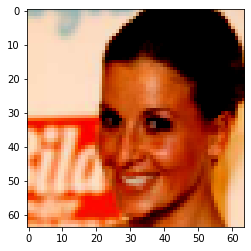

In [ ]:
plt.imshow(y)

### Utils

In [ ]:
def show_image(im_data, scale=1):
    dpi = matplotlib.rcParams['figure.dpi']
    height, width = im_data.shape
    figsize = scale * width / float(dpi), scale * height / float(dpi)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')
    ax.imshow(im_data, vmin=0, vmax=1, cmap='gray')
    plt.show();
    ax.set(xlim=[0, width], ylim=[height, 0], aspect=1)


class RAdam(Optimizer):
    def __init__(
        self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, degenerated_to_sgd=True
    ):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        if isinstance(params, (list, tuple)) and len(params) > 0 and isinstance(params[0], dict):
            for param in params:
                if "betas" in param and (
                    param["betas"][0] != betas[0] or param["betas"][1] != betas[1]
                ):
                    param["buffer"] = [[None, None, None] for _ in range(10)]
        defaults = dict(
            lr=lr,
            betas=betas,
            eps=eps,
            weight_decay=weight_decay,
            buffer=[[None, None, None] for _ in range(10)],
        )
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError("RAdam does not support sparse gradients")

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state["step"] = 0
                    state["exp_avg"] = torch.zeros_like(p_data_fp32)
                    state["exp_avg_sq"] = torch.zeros_like(p_data_fp32)
                else:
                    state["exp_avg"] = state["exp_avg"].type_as(p_data_fp32)
                    state["exp_avg_sq"] = state["exp_avg_sq"].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]
                beta1, beta2 = group["betas"]

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state["step"] += 1
                buffered = group["buffer"][int(state["step"] % 10)]
                if state["step"] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state["step"]
                    beta2_t = beta2 ** state["step"]
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state["step"] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt(
                            (1 - beta2_t)
                            * (N_sma - 4)
                            / (N_sma_max - 4)
                            * (N_sma - 2)
                            / N_sma
                            * N_sma_max
                            / (N_sma_max - 2)
                        ) / (1 - beta1 ** state["step"])
                    elif self.degenerated_to_sgd:
                        step_size = 1.0 / (1 - beta1 ** state["step"])
                    else:
                        step_size = -1
                    buffered[2] = step_size

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    if group["weight_decay"] != 0:
                        p_data_fp32.add_(-group["weight_decay"] * group["lr"], p_data_fp32)
                    denom = exp_avg_sq.sqrt().add_(group["eps"])
                    p_data_fp32.addcdiv_(-step_size * group["lr"], exp_avg, denom)
                    p.data.copy_(p_data_fp32)
                elif step_size > 0:
                    if group["weight_decay"] != 0:
                        p_data_fp32.add_(-group["weight_decay"] * group["lr"], p_data_fp32)
                    p_data_fp32.add_(-step_size * group["lr"], exp_avg)
                    p.data.copy_(p_data_fp32)

        return loss


# Mish - "Mish: A Self Regularized Non-Monotonic Neural Activation Function"
# https://arxiv.org/abs/1908.08681v1
# implemented for PyTorch / FastAI by lessw2020
# github: https://github.com/lessw2020/mish
def mish(x):
    return x * torch.tanh(F.softplus(x))


class Mish(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return mish(x)
    
# https://pytorch.org/docs/stable/_modules/torch/optim/lr_scheduler.html
class FlatCA(_LRScheduler):
    def __init__(self, optimizer, steps, eta_min=0, last_epoch=-1):
        self.steps = steps
        self.eta_min = eta_min
        super(FlatCA, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        lr_list = []
        T_max = self.steps / 3
        for base_lr in self.base_lrs:
            # flat if first 2/3
            if 0 <= self._step_count < 2 * T_max:
                lr_list.append(base_lr)
            # annealed if last 1/3
            else:
                lr_list.append(
                    self.eta_min
                    + (base_lr - self.eta_min)
                    * (1 + math.cos(math.pi * (self._step_count - 2 * T_max) / T_max))
                    / 2
                )
            return lr_list

### Architecture

In [ ]:
class Encoder(nn.Module):
    """ Downsamples by a fac of 2 """

    def __init__(self, in_feat_dim, codebook_dim, hidden_dim=128, num_res_blocks=0):
        super().__init__()
        blocks = [
            nn.Conv2d(in_feat_dim, hidden_dim // 2, kernel_size=3, stride=2, padding=1),
            Mish(), # Activation function x * torch.tanh(F.softplus(x))
            nn.Conv2d(hidden_dim // 2, hidden_dim, kernel_size=3, padding=1),
            Mish(), # Activation function x * torch.tanh(F.softplus(x))
        ]

        for _ in range(num_res_blocks):
            blocks.append(ResBlock(hidden_dim, hidden_dim // 2))

        blocks.append(nn.Conv2d(hidden_dim, codebook_dim, kernel_size=1))
        self.blocks = nn.Sequential(*blocks)

    def forward(self, x):
        return self.blocks(x)


class Decoder(nn.Module):
    """ Upsamples by a fac of 2 """

    def __init__(
        self, in_feat_dim, out_feat_dim, hidden_dim=128, num_res_blocks=0, very_bottom=False,
    ):
        super().__init__()
        self.very_bottom = very_bottom
        self.out_feat_dim = out_feat_dim # num channels on bottom layer

        blocks = [nn.Conv2d(in_feat_dim, hidden_dim, kernel_size=3, padding=1), Mish()]

        for _ in range(num_res_blocks):
            blocks.append(ResBlock(hidden_dim, hidden_dim // 2))

        blocks.extend([
                Upsample(),
                nn.Conv2d(hidden_dim, hidden_dim // 2, kernel_size=3, padding=1),
                Mish(),
                nn.Conv2d(hidden_dim // 2, out_feat_dim, kernel_size=3, padding=1),
        ])

        if very_bottom is True:
            blocks.append(nn.Sigmoid())       
        
        self.blocks = nn.Sequential(*blocks)

    def forward(self, x):
        return self.blocks(x)


class Upsample(nn.Module):
    def __init__(self, scale_factor=2):
        super().__init__()
        self.scale_factor = scale_factor

    def forward(self, x):
        return F.interpolate(x, scale_factor=self.scale_factor)


class ResBlock(nn.Module):
    def __init__(self, in_channel, channel):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channel, channel, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv2d(channel, in_channel, kernel_size=3, padding=1)

    def forward(self, inp):
        x = self.conv_1(inp)
        x = mish(x)
        x = self.conv_2(x)
        x = x + inp
        return mish(x)

In [ ]:
class VQCodebook(nn.Module):
    def __init__(self, codebook_slots, codebook_dim, temperature=0.5):
        super().__init__()
        self.codebook_slots = codebook_slots
        self.codebook_dim = codebook_dim
        self.temperature = temperature
        self.codebook = nn.Parameter(torch.randn(codebook_slots, codebook_dim))
        self.log_slots_const = np.log(self.codebook_slots)

    def z_e_to_z_q(self, z_e, soft=True):
        bs, feat_dim, w, h = z_e.shape
        assert feat_dim == self.codebook_dim
        z_e = z_e.permute(0, 2, 3, 1).contiguous()
        z_e_flat = z_e.view(bs * w * h, feat_dim)
        codebook_sqr = torch.sum(self.codebook ** 2, dim=1)
        z_e_flat_sqr = torch.sum(z_e_flat ** 2, dim=1, keepdim=True)

        distances = torch.addmm(  # matrix multiplication
            codebook_sqr + z_e_flat_sqr, z_e_flat, self.codebook.t(), alpha=-2.0, beta=1.0
        )

        if soft is True:
            dist = RelaxedOneHotCategorical(self.temperature, logits=-distances)
            soft_onehot = dist.rsample()
            hard_indices = torch.argmax(soft_onehot, dim=1).view(bs, w, h)
            z_q = (soft_onehot @ self.codebook).view(bs, w, h, feat_dim)
            
            # entropy loss
            KL = dist.probs * (dist.probs.add(1e-9).log() + self.log_slots_const)
            KL = KL.view(bs, w, h, self.codebook_slots).sum(dim=(1,2,3)).mean()
            
            # probability-weighted commitment loss    
            commit_loss = (dist.probs.view(bs, w, h, self.codebook_slots) * distances.view(bs, w, h, self.codebook_slots)).sum(dim=(1,2,3)).mean()
        else:
            with torch.no_grad():
                dist = Categorical(logits=-distances)
                hard_indices = dist.sample().view(bs, w, h)
                hard_onehot = (
                    F.one_hot(hard_indices, num_classes=self.codebook_slots)
                    .type_as(self.codebook)
                    .view(bs * w * h, self.codebook_slots)
                )
                z_q = (hard_onehot @ self.codebook).view(bs, w, h, feat_dim)
                
                # entropy loss
                KL = dist.probs * (dist.probs.add(1e-9).log() + np.log(self.codebook_slots))
                KL = KL.view(bs, w, h, self.codebook_slots).sum(dim=(1,2,3)).mean()

                commit_loss = 0.0

        z_q = z_q.permute(0, 3, 1, 2)

        return z_q, hard_indices, KL, commit_loss

    def lookup(self, ids: torch.Tensor):
        return F.embedding(ids, self.codebook).permute(0, 3, 1, 2)

    def quantize(self, z_e, soft=False):
        with torch.no_grad():
            z_q, indices, _, _ = self.z_e_to_z_q(z_e, soft=soft)
        return z_q, indices

    def quantize_indices(self, z_e, soft=False):
        with torch.no_grad():
            _, indices, _, _ = self.z_e_to_z_q(z_e, soft=soft)
        return indices

    def forward(self, z_e):
        z_q, indices, kl, commit_loss = self.z_e_to_z_q(z_e, soft=True)
        return z_q, indices, kl, commit_loss

In [ ]:
class GlobalNormalization(torch.nn.Module):
    """
    nn.Module to track and normalize input variables, calculates running estimates of data
    statistics during training time.
    Optional scale parameter to fix standard deviation of inputs to 1
    Normalization atlassian page:
    https://speechmatics.atlassian.net/wiki/spaces/INB/pages/905314814/Normalization+Module
    Implementation details:
    "https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Welford's_online_algorithm"
    """

    def __init__(self, feature_dim, scale=False):
        super().__init__()
        self.feature_dim = feature_dim
        self.register_buffer("running_ave", torch.zeros(1, self.feature_dim, 1, 1))
        self.register_buffer("total_frames_seen", torch.Tensor([0]))
        self.scale = scale
        if self.scale:
            self.register_buffer("running_sq_diff", torch.zeros(1, self.feature_dim, 1, 1))

    def forward(self, inputs):

        if self.training:
            # Update running estimates of statistics
            frames_in_input = inputs.shape[0] * inputs.shape[2] * inputs.shape[3]
            updated_running_ave = (
                self.running_ave * self.total_frames_seen + inputs.sum(dim=(0, 2, 3), keepdim=True)
            ) / (self.total_frames_seen + frames_in_input)

            if self.scale:
                # Update the sum of the squared differences between inputs and mean
                self.running_sq_diff = self.running_sq_diff + (
                    (inputs - self.running_ave) * (inputs - updated_running_ave)
                ).sum(dim=(0, 2, 3), keepdim=True)

            self.running_ave = updated_running_ave
            self.total_frames_seen = self.total_frames_seen + frames_in_input

        if self.scale:
            std = torch.sqrt(self.running_sq_diff / self.total_frames_seen)
            inputs = (inputs - self.running_ave) / std
        else:
            inputs = inputs - self.running_ave

        return inputs

    def unnorm(self, inputs):
        if self.scale:
            std = torch.sqrt(self.running_sq_diff / self.total_frames_seen)
            inputs = inputs*std + self.running_ave
        else:
            inputs = inputs + self.running_ave

        return inputs

In [ ]:
class HQA(nn.Module):
    def __init__(
        self,
        prev_model,
        input_feat_dim,
        codebook_slots=256,
        codebook_dim=64,
        enc_hidden_dim=16,
        dec_hidden_dim=32,
        gs_temp=0.667,
    ):
        super().__init__()
        self.prev_model = prev_model
        self.encoder = Encoder(input_feat_dim, codebook_dim, enc_hidden_dim)
        self.codebook = VQCodebook(codebook_slots, codebook_dim, gs_temp)
        self.decoder = Decoder(
            codebook_dim,
            input_feat_dim,
            dec_hidden_dim,
            very_bottom=prev_model is None,
        )
        self.normalize = GlobalNormalization(codebook_dim, scale=True)

    def parameters(self, prefix="", recurse=True):
        for module in [self.encoder, self.codebook, self.decoder]:
            for name, param in module.named_parameters(recurse=recurse):
                yield param

    @classmethod
    def init_higher(cls, prev_model, **kwargs):
        model = HQA(prev_model, prev_model.codebook.codebook_dim, **kwargs)
        model.prev_model.eval()
        return model
    
    @classmethod
    def init_bottom(cls, input_feat_dim, **kwargs):
        model = HQA(None, input_feat_dim, **kwargs)
        return model
        
    def forward(self, img):
        z_e_lower = self.encode_lower(img)
        z_e = self.encoder(z_e_lower)
        z_q, indices, kl, commit_loss = self.codebook(z_e)
        z_e_lower_tilde = self.decoder(z_q)
        return z_e_lower_tilde, z_e_lower, z_q, z_e, indices, kl, commit_loss
   
    def forward_full_stack(self, img):
        z_e = self.encode(img)
        z_q, indices, kl, commit_loss = self.codebook(z_e)
        img_recon_dist = self.decode(z_q)
        return img_recon_dist, img, z_q, z_e, indices, kl, commit_loss

    def encode_lower(self, x):
        if self.prev_model is None:
            return x
        else:
            with torch.no_grad():
                z_e_lower = self.prev_model.encode(x)
                z_e_lower = self.normalize(z_e_lower)
            return z_e_lower

    def encode(self, x):
        with torch.no_grad():
            z_e_lower = self.encode_lower(x)
            z_e = self.encoder(z_e_lower)
        return z_e
        
    def decode_lower(self, z_q_lower):
        with torch.no_grad():
            recon = self.prev_model.decode(z_q_lower)           
        return recon

    def decode(self, z_q):
        with torch.no_grad():
            if self.prev_model is not None:
                z_e_u = self.normalize.unnorm(self.decoder(z_q))
                z_q_lower_tilde = self.prev_model.quantize(z_e_u)
                recon = self.decode_lower(z_q_lower_tilde)
            else:
                recon = self.decoder(z_q)
        return recon

    def quantize(self, z_e):
        z_q, _ = self.codebook.quantize(z_e)
        return z_q

    def reconstruct_average(self, x, num_samples=10):
        """Average over stochastic edecodes"""
        b, c, h, w = x.shape
        result = torch.empty((num_samples, b, c, h, w)).to(device)

        for i in range(num_samples):
            result[i] = self.decode(self.quantize(self.encode(x)))
        return result.mean(0)

    def reconstruct(self, x):
        return self.decode(self.quantize(self.encode(x)))
    
    def reconstruct_from_codes(self, codes):
        return self.decode(self.codebook.lookup(codes))
    
    def reconstruct_from_z_e(self, z_e):
        return self.decode(self.quantize(z_e))
    
    def recon_loss(self, orig, recon):
        return F.mse_loss(orig, recon, reduction='none').sum(dim=(1,2,3)).mean()

    def __len__(self):
        i = 1
        layer = self
        while layer.prev_model is not None:
            i += 1
            layer = layer.prev_model
        return i

    def __getitem__(self, idx):
        max_layer = len(self) - 1
        if idx > max_layer:
            raise IndexError("layer does not exist")

        layer = self
        for _ in range(max_layer - idx):
            layer = layer.prev_model
        return layer

### Training

In [ ]:
def show_recon(img, *models):
    # fig, axes = plt.subplots(nrows=1, ncols=len(models), figsize=(10 * len(models), 5))

    # if not isinstance(axes, np.ndarray):
    #     axes = np.array([axes])

    for i, model in enumerate(models):
        model.eval()
    
   
        img_ = img.unsqueeze(0)
        # print(f"image_shape after unsqueeze {img_.shape}")
        recon = model.reconstruct(img_).squeeze()
        # print(f"recon {recon.shape}")
        # print(f"recon.cpu() {recon.cpu().shape}")
        # print(f"np.ones([img.shape[0], 1]) {np.ones([img.shape[0],1,  img.shape[1]]).shape}")
        padding = np.ones([img.shape[0],  img.shape[1], img.shape[1]])
        # print(f"np.rot90(img.cpu(), k=3) , {np.rot90(img.cpu(), k=3).shape}")
        # print(f"np.rot90(padding, k=3) , {np.rot90(padding, k=3).shape}")
        # output = np.hstack([
        #                     np.swapaxes(np.rot90(img.cpu(), k=3), 1,-1),
        #                     np.swapaxes(np.rot90(padding, k=3), 1,-1),
        #                     np.swapaxes(np.rot90(recon.cpu(), k=3), 1,-1),
        #                     np.swapaxes(np.rot90(padding, k=3), 1,-1),
        #                     np.swapaxes(np.rot90(np.abs((img-recon).cpu()), k=3), 1,-1),
        #                     ])
        # output = np.hstack([
        #                     img.cpu(),
        #                     padding, 
        #                     recon.cpu(),
        #                     padding,
        #                     np.abs((img-recon).cpu()),
        #                     ])
        #  output = torch.tensor(output).permute(2,1,0)
        img = np.moveaxis(img.cpu().detach().numpy(), 0, -1)
        recons =  np.moveaxis(recon.cpu().detach().numpy(),0 , -1)
        diff = np.abs((img-recons))
        _, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,5))
        ax1.imshow( img, vmin=0, vmax=1)
        ax2.imshow( recons, vmin=0, vmax=1)
        ax3.imshow( diff, vmin=0, vmax=1)
        model.train()


def get_bit_usage(indices):
    """ Calculate bits used by latent space vs max possible """
    num_latents = indices.shape[0] * indices.shape[1] * indices.shape[2]
    avg_probs = F.one_hot(indices).float().mean(dim=(0, 1, 2, 3))
    highest_prob = torch.max(avg_probs)
    bits = (-(avg_probs * torch.log2(avg_probs + 1e-10)).sum()) * num_latents
    max_bits = math.log2(256) * num_latents
    return bits, max_bits, highest_prob


def decay_temp_linear(step, total_steps, temp_base, temp_min=0.001):
    factor = 1.0 - (step/total_steps)
    return temp_min + (temp_base - temp_min) * factor

In [ ]:
def get_loss_hqa(img, model, epoch, step, commit_threshold=0.6, log=None):
    recon, orig, z_q, z_e, indices, KL, commit_loss = model(img)
    recon_loss = model.recon_loss(orig, recon)
    
    # calculate loss
    dims = np.prod(recon.shape[1:]) # orig_w * orig_h * num_channels
    loss = recon_loss/dims + 0.001*KL/dims + 0.001*(commit_loss)/dims
    
    # logging    
    if step % 20 == 0:
        nll = recon_loss
        elbo = -(nll + KL)  
        distortion_bpd = nll / dims / np.log(2)
        rate_bpd = KL / dims / np.log(2)
        
        bits, max_bits, highest_prob = get_bit_usage(indices)
        bit_usage_frac = bits / max_bits
        
        time = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")
        log_line = f"{time}, epoch={epoch}, step={step}, loss={loss:.5f}, distortion={distortion_bpd:.3f}, rate={rate_bpd:.3f}, -elbo={-elbo:.5f}, nll={nll:.5f}, KL={KL:.5f}, commit_loss={commit_loss:.5f}, bit_usage={bit_usage_frac:.5f}, highest_prob={highest_prob:.3f}, temp={model.codebook.temperature:.5f}"
        print(log_line)

        if log is not None:
            with open(log, "a") as logfile:
                logfile.write(log_line + "\n")
                
    return loss, indices


def train(model, optimizer, scheduler, epochs, decay=True, log=None):
    step = 0
    model.train()
    temp_base = model.codebook.temperature
    code_count = torch.zeros(model.codebook.codebook_slots).to(device)
    total_steps = len(dl_train)*epochs
    
    for epoch in range(epochs):
        for x in dl_train:
            x = x.to(device)
            
            # anneal temperature
            if decay is True:
                model.codebook.temperature = decay_temp_linear(step+1, total_steps, temp_base, temp_min=0.001) 
            
            loss, indices = get_loss_hqa(x, model, epoch, step, log=log)
                
            # take training step    
            model.zero_grad()
            loss.backward()
            clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            if scheduler is not None:
                scheduler.step()     
                
            # code reset every 20 steps
            indices_onehot = F.one_hot(indices, num_classes=model.codebook.codebook_slots).float()
            code_count = code_count + indices_onehot.sum(dim=(0, 1, 2, 3))
            if step % 20 == 0:
                with torch.no_grad():
                    max_count, most_used_code = torch.max(code_count, dim=0)
                    frac_usage = code_count / max_count
                    z_q_most_used = model.codebook.lookup(most_used_code.view(1, 1, 1)).squeeze()

                    min_frac_usage, min_used_code = torch.min(frac_usage, dim=0)
                    if min_frac_usage < 0.03:
                        print(f'reset code {min_used_code}')
                        moved_code = z_q_most_used + torch.randn_like(z_q_most_used) / 100
                        model.codebook.codebook[min_used_code] = moved_code
                    code_count = torch.zeros_like(code_count)

            step += 1
        if epoch % 5 == 0:
            for n in range(0, 5):
                reshaped = test_x[n].reshape((3,64,64))
                show_recon(reshaped, model)
                plt.show();

In [ ]:
def train_full_stack(root, exp_name, epochs=150, lr=4e-4):
    
    enc_hidden_sizes = [16, 16, 32, 64, 128]
    dec_hidden_sizes = [16, 64, 256, 512, 1024]
    
    os.makedirs(root + "/log", exist_ok=True)
    
    for i in range(5):
        print(f"training layer{i}")
        if i == 0:
            hqa = HQA.init_bottom(
                input_feat_dim=3, # over here the number of initial channels (Grayscale = 1 , RGB = 3)
                enc_hidden_dim=enc_hidden_sizes[i],
                dec_hidden_dim=dec_hidden_sizes[i],
            ).to(device)
        else:
            hqa = HQA.init_higher(
                hqa_prev,
                enc_hidden_dim=enc_hidden_sizes[i],
                dec_hidden_dim=dec_hidden_sizes[i],
            ).to(device)
        
        print(f"layer{i} param count {sum(x.numel() for x in hqa.parameters()):,}")
        
        log_file = f"{root}/log/{exp_name}_l{i}.log"
        opt = RAdam(hqa.parameters(), lr=lr)
        scheduler = FlatCA(opt, steps=epochs*len(dl_train), eta_min=lr/10)
        train(hqa, opt, scheduler, epochs, log=log_file)
        hqa_prev = hqa
    
    torch.save(hqa, f"{root}/{exp_name}.pt")
    
    return hqa

### Train HQA Stack

training layer0
layer0 param count 29,475
18/04/2021 12:25:28, epoch=0, step=0, loss=0.70994, distortion=1.019, rate=0.559, -elbo=13438.02051, nll=8678.57812, KL=4759.44238, commit_loss=40409.07812, bit_usage=0.00391, highest_prob=0.004, temp=0.66589


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


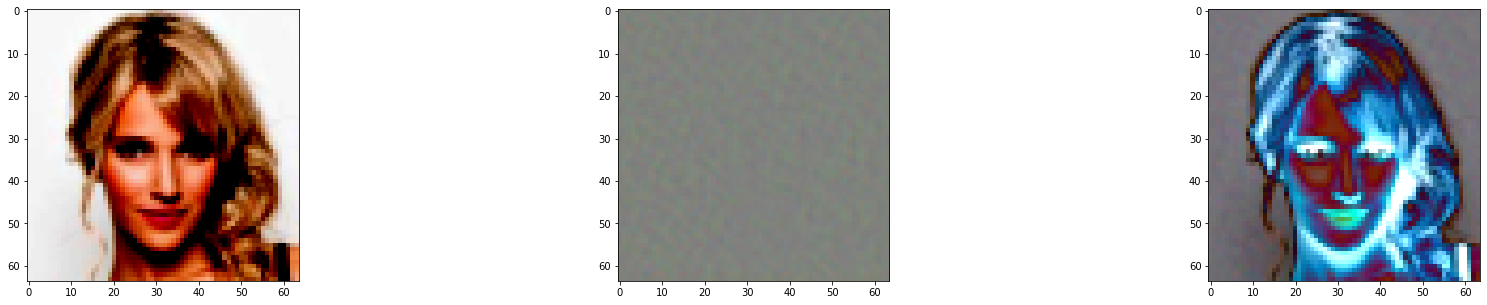

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


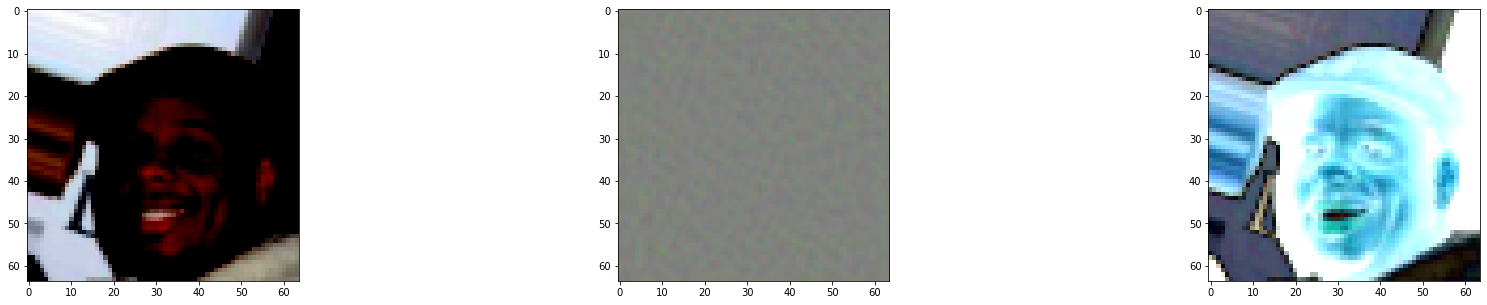

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


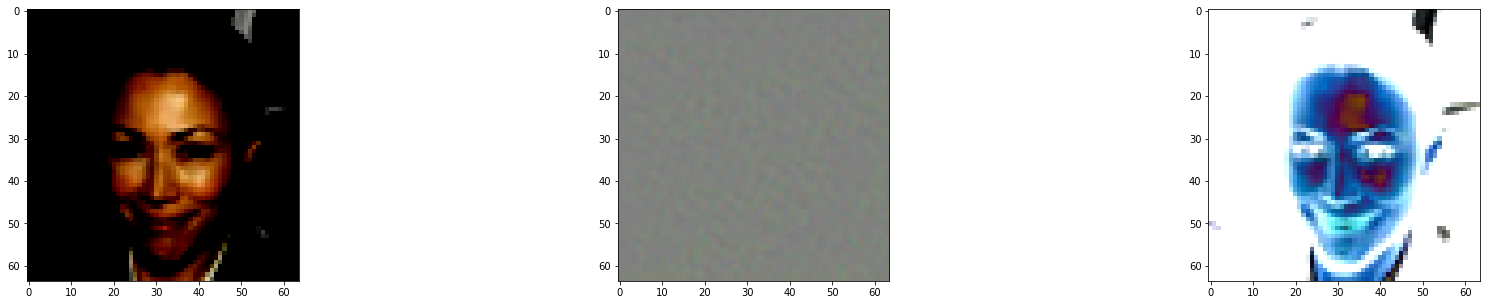

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


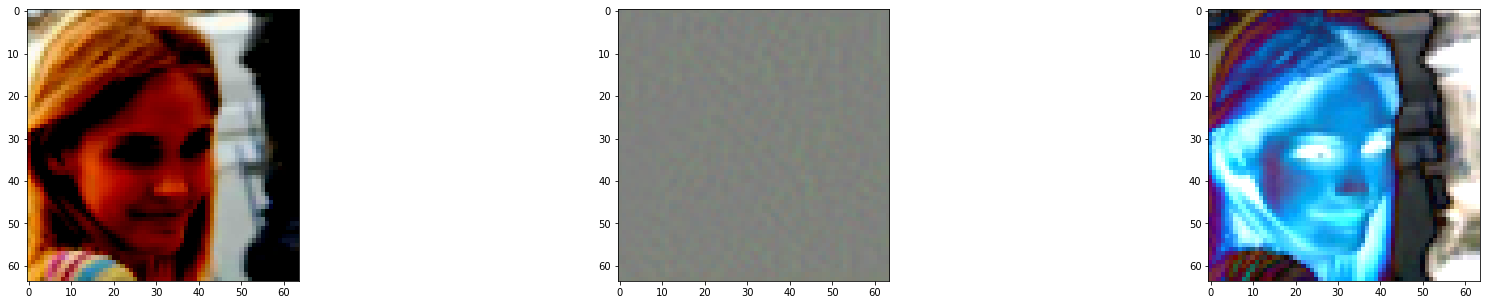

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


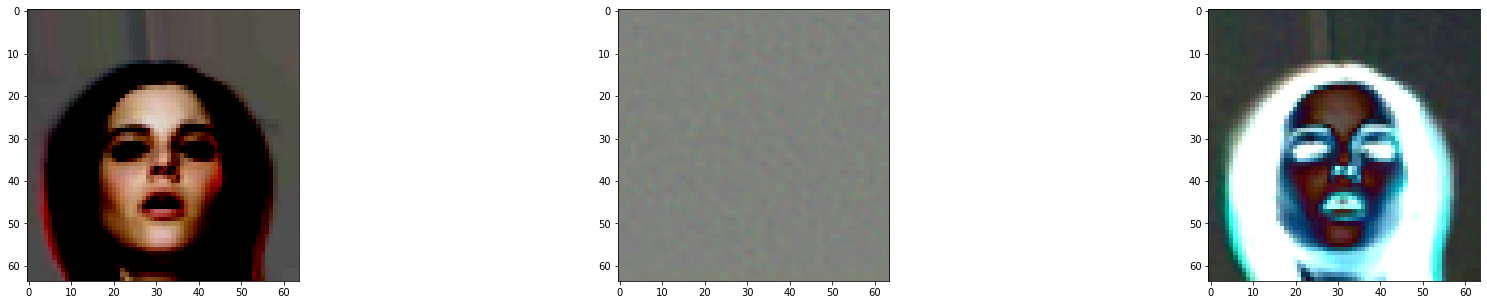

18/04/2021 12:25:40, epoch=5, step=20, loss=0.73102, distortion=1.049, rate=0.554, -elbo=13656.63867, nll=8937.51953, KL=4719.11914, commit_loss=40490.09766, bit_usage=0.00391, highest_prob=0.004, temp=0.64369


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


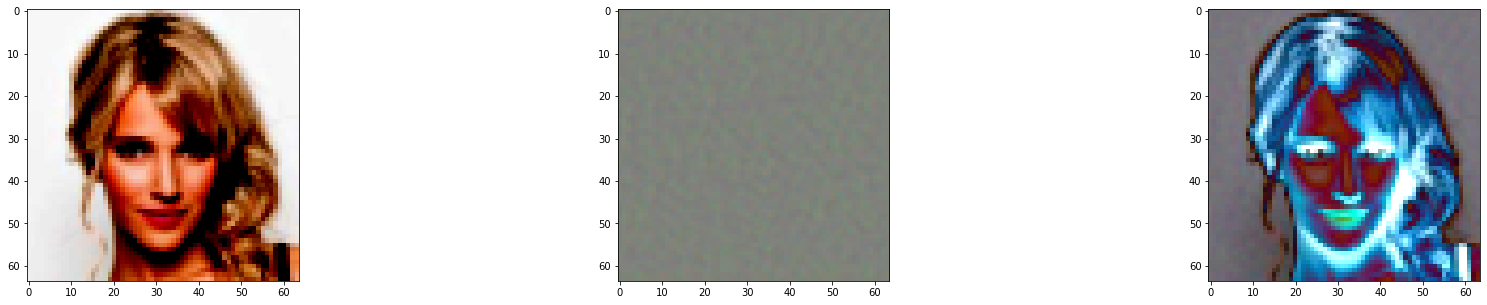

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


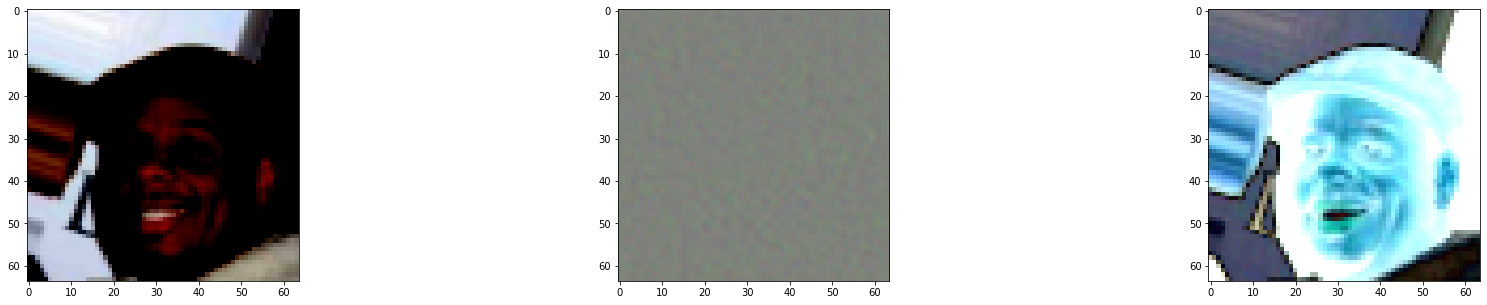

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


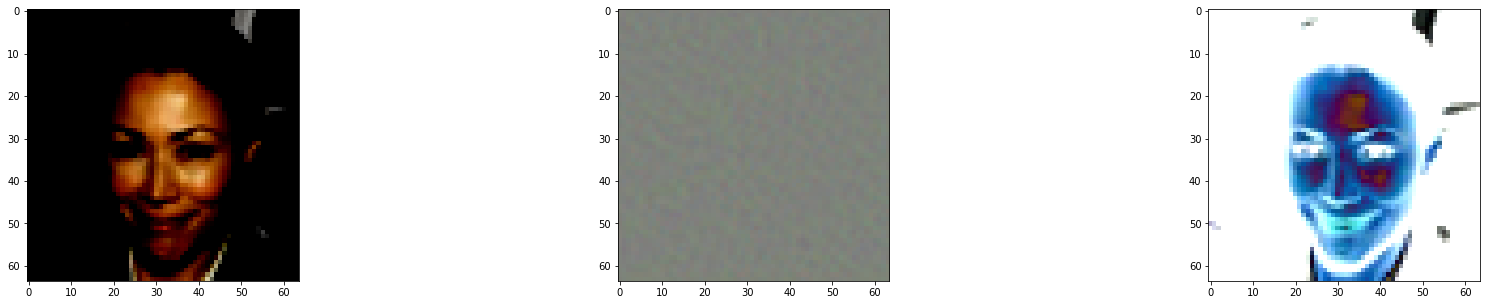

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


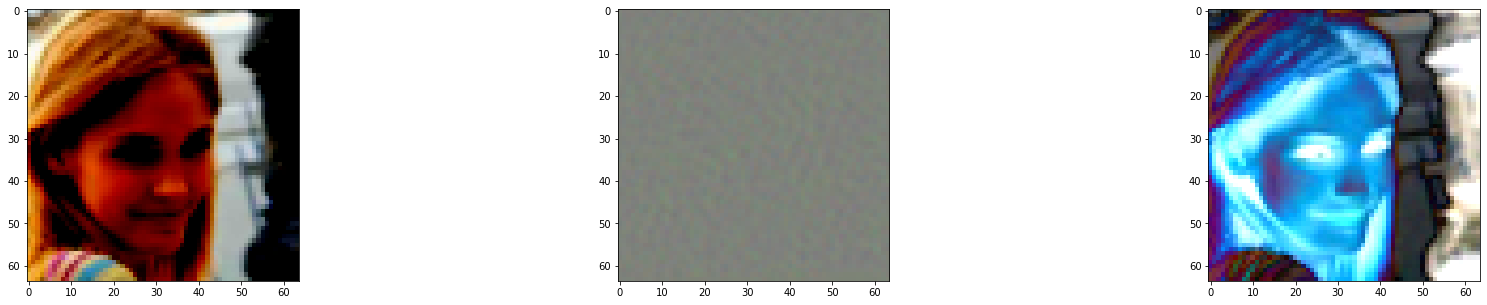

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


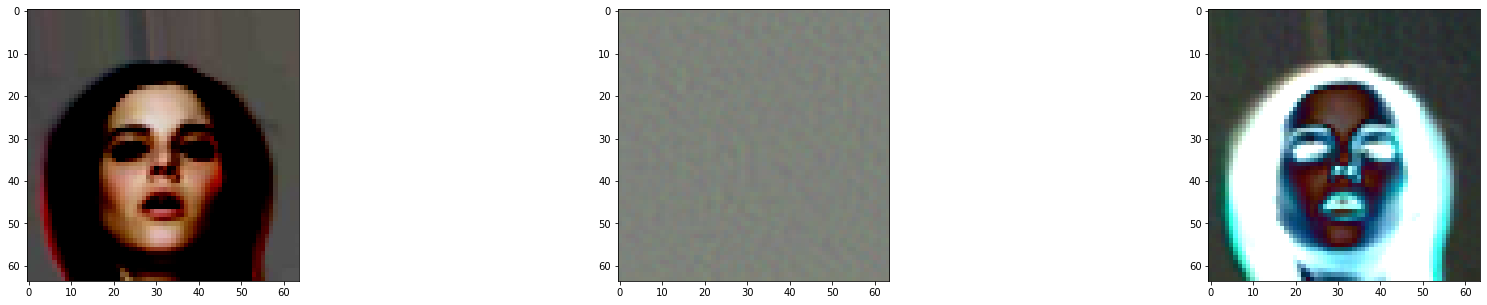

KeyboardInterrupt: ignored

In [ ]:
# Train a HQA stack
model_name = "hqa_model"
models_dir = f"{os.getcwd()}/models"
os.makedirs(models_dir, exist_ok=True)


# if not os.path.isfile(f"{models_dir}/{model_name}.pt"):
hqa_model = train_full_stack(models_dir, model_name, epochs=150)
# else:
#     hqa_model = torch.load(f"{models_dir}/{model_name}.pt")

hqa_model.eval()
    
layer_names = ["Layer 0", "Layer 1", "Layer 2", "Layer 3", "Layer 4 Final"]
layer_descriptions = [
    "downsample 2 in each dimension, latent space size of 16x16",
    "downsample 4 in each dimension, latent space size of 8x8",
    "downsample 8 in each dimension, latent space size of 4x4",
    "downsample 16 in each dimension, latent space size of 2x2",
    "downsample 32 in each dimension, latent space size of 1x1",
]
torch.save(hqa_model.state_dict(), f"{models_dir}/{model_name}.pt")

### Layer Reconstructions
Final layer recons match HQA recons from Table 3

In [ ]:
def recon_comparison(model, names, descriptions, indexes=[0, 4, 15, 16, 18]):
    images = []
    for idx in indexes:
        image = celeba_dataset[idx]    
        img = image.to(device).squeeze()
        images.append(img.cpu().numpy())
    print("Original images to be reconstructed")
    output = np.hstack(images)
    show_image(output)
    
    for layer, name, description in zip(model, names, descriptions):
        images = []
        
        for idx in indexes:
            image = celeba_dataset[idx]    
            img = image.to(device).squeeze()
            
            for_recon = img.unsqueeze(0).unsqueeze(0)
            layer.eval()
            recon = layer.reconstruct(for_recon).squeeze()
            images.append(recon.cpu().numpy())
        
        print(f"{name}: {description}")
        output = np.hstack(images)
        show_image(output)

In [ ]:
# Show reconstruction comparison over each layer in HQA
recon_comparison(hqa_model, layer_names, layer_descriptions)

### Distortions
HQA distortions in Figure 3

In [ ]:
def get_rate_upper_bound(model, example_input):
    assert len(example_input.shape) == 4, "Expected (1, num_channels, x_h, x_w)"
    assert example_input.shape[0] == 1, "Please provide example with batch_size=1"
    
    z_e = model.encode(example_input)
    _, top_indices, _, _ = model.codebook(z_e)
        
    # assume worst case scenario: we have a uniform usage of all our codes
    rate_bound = top_indices[0].numel() * np.log2(model.codebook.codebook_slots)

    return rate_bound

def test(model):
    model.eval()
    total_nll = []
    total_kl = []
    
    for x in dl_train:
        img = x.to(device)       
        recon, orig, z_q, z_e, indices, kl, _ = model.forward_full_stack(img)       
        recon_loss = model[0].recon_loss(img, recon)        
        total_nll.append(recon_loss.item())
        if kl != 0:
            total_kl.append(kl.item())
        else:
            total_kl.append(kl)
    
    dims = np.prod(x.shape[1:])
    kl_mean = np.mean(total_kl)
    nll_mean = np.mean(total_nll)
    distortion_bpd = nll_mean / dims / np.log(2)
    rate_bpd = kl_mean / dims / np.log(2)
    elbo = -(nll_mean + kl_mean)
    
    rate_bound = get_rate_upper_bound(model, img[0].unsqueeze(0))
    
    return distortion_bpd, rate_bound


def get_rd_data(model):
    dist = []
    rates = []
    
    for i, _ in enumerate(model):
        d, r = test(model[i])
        dist.append(float(d))
        rates.append(float(r))
    
    return dist, rates

In [ ]:
# Layer distortions
distortions, rates = get_rd_data(hqa_model)
print("Name \t\t Distortion \t Rate")
for dist, rate, name in zip(distortions, rates, layer_names):
    print(f"{name} \t {dist:.4f} \t {int(rate)}")

### "Free" Samples: enumerating over all 1x1 latents
Appendix Figure 4

In [ ]:
num_codes = hqa_model.codebook.codebook_slots
results = torch.Tensor(num_codes, 1, 32, 32).to(device)
count=0
for i in range(num_codes):
    codes = torch.LongTensor([i]).unsqueeze(0).unsqueeze(0).to(device)
    results[count] = hqa_model.reconstruct_from_codes(codes)
    count += 1
        
grid_img = make_grid(results.cpu(), nrow=16)
show_image(grid_img[0,:,:])

### Final Layer Interpolations
Appendix Figure 5

In [ ]:
grid_x = grid_y = 16
results = torch.Tensor(grid_x * grid_y, 1, 32, 32)
i = 0

for j in range(grid_y):
    x_a = celeba_dataset[j]
    x_b= celeba_dataset[j+grid_y]
    point_1 = hqa_model.encode(x_a.unsqueeze(0).to(device)).cpu()
    point_2 = hqa_model.encode(x_b.unsqueeze(0).to(device)).cpu()
    interpolate_x = np.linspace(point_1[0], point_2[0], grid_x)

    for z_e_interpolated in interpolate_x:
        z_e_i = torch.Tensor(z_e_interpolated).unsqueeze(0).to(device)
        z_q = hqa_model.quantize(z_e_i)
        results[i] = hqa_model.decode(z_q).squeeze()
        i += 1
            
grid_img = make_grid(results.cpu(), nrow=grid_x)
show_image(grid_img[0,:,:])

### Stochastic Reconstructions
Appendix Figure 6

In [ ]:
# Show held-out reconstructions: [ORIG, 14xSAMPLE, AVERAGED_10_SAMPLES]
grid_x = grid_y = 16
results = torch.Tensor(grid_x * grid_y, 1, 32, 32)

result_idx = 0
for test_idx in range(grid_y):
    x_a = celeba_dataset[test_idx]
    img = x_a.squeeze().to(device)
    img_ = img.unsqueeze(0).unsqueeze(0)
    num_examples = 5
    
    # ORIG
    results[result_idx] = img
    result_idx += 1
    
    # 14 RANDOM STOCHASTIC DECODES
    for _ in range(grid_x -2):
        results[result_idx] = hqa_model.reconstruct(img_).squeeze()
        result_idx += 1
    
    # AVERAGED SAMPLES
    results[result_idx] = hqa_model.reconstruct_average(img_, num_samples=14).squeeze()
    result_idx += 1

grid_img = make_grid(results.cpu(), nrow=grid_x)
show_image(grid_img[0,:,:])

### Layer-wise Interpolations
Appendix Table 7

In [ ]:
def interpolate(a, b, vqvae, grid_x=16):
    images = []
    
    x_a = celeba_dataset[a]
    x_b = celeba_dataset[b]
    point_1 = vqvae.encode(x_a.unsqueeze(0).to(device))
    point_2 = vqvae.encode(x_b.unsqueeze(0).to(device))

    interpolate_x = np.linspace(point_1[0].cpu().numpy(), point_2[0].cpu().numpy(), grid_x)
    
    results = torch.Tensor(len(interpolate_x), 1, 32, 32)
    for i, z_e_interpolated in enumerate(interpolate_x):       
        z_e = torch.Tensor(z_e_interpolated).unsqueeze(0).to(device)
        z_q = vqvae.quantize(z_e)
        recon = vqvae.decode(z_q).squeeze() 
        results[i] = recon

    grid_img = make_grid(results.cpu(), nrow=grid_x)
    show_image(grid_img[0,:,:])

def show_original(idx):
    x= celeba_dataset[idx]
    image = x.squeeze()
    show_image(image)
    
print("Originals")
show_original(1)
show_original(9)
for layer, name, description in zip(hqa_model, layer_names, layer_descriptions):
    print(f"{name} : {description}")
    interpolate(1, 9, layer, grid_x=10)